# Random forest testing

In [18]:
# Optimimized Random Forest after running Grid Search CV.

# Training and Testing robustness of Model

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle  # Import pickle for model serialization

def run_optimized_random_forest(csv_file_path, target_column):
    """
    Loads data, trains a Random Forest model with optimized parameters, evaluates its performance,
    and saves the trained model to a file.

    Parameters:
        csv_file_path (str): Path to the CSV file containing the dataset.
        target_column (str): The name of the target variable column in the dataset.

    Returns:
        None
    """
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Separate the features and the target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the Random Forest model with the best parameters from previous optimization
    model = RandomForestClassifier(
        n_estimators=200,
        max_depth=30,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Save the trained model to a file
    with open('bike_type_classifier.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model using accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=skf)
    print(f'Average CV Accuracy: {cv_scores.mean()} ± {cv_scores.std()}')

    # Feature importances
    feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    print("Feature Importances:")
    print(feature_importances)
    
    print("Model saved to bike_type_classifier.pkl")

# Enter Data:
if __name__ == "__main__":
    csv_file_path = 'encoded_road_bikes_2020-2024.csv'  # Replace with your actual CSV file path
    target_column = 'subcategory'  # Replace with the actual name of your target column
    run_optimized_random_forest(csv_file_path, target_column)


Accuracy: 0.9817234240022845
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5428
           1       0.99      0.97      0.98      3362
           2       0.99      0.99      0.99      2607
           3       0.89      0.97      0.93      1144
           4       0.97      0.94      0.95       540
           5       0.99      0.98      0.98       518
           6       1.00      0.97      0.98       281
           7       0.94      0.73      0.82        66
           8       1.00      0.98      0.99        61

    accuracy                           0.98     14007
   macro avg       0.97      0.95      0.96     14007
weighted avg       0.98      0.98      0.98     14007

Confusion Matrix:
[[5424    1    0    0    0    3    0    0    0]
 [   5 3249   10   95    0    0    0    3    0]
 [  16   13 2570    4    1    3    0    0    0]
 [   0   14    0 1115   15    0    0    0    0]
 [   0    0    3   31  506    0    0    0    0]
 [   9  

Explanation of the Script
Dataset Loading: The dataset is loaded from a CSV file.
Feature Separation: Features and the target variable are separated.
Data Splitting: The dataset is split into training and test sets to ensure that the model can be evaluated on unseen data.
Model Initialization: The RandomForestClassifier is initialized with the best parameters identified from the GridSearchCV. These parameters are intended to optimize the model's performance.
Model Training: The model is trained on the training data.
Prediction and Evaluation: The model makes predictions on the test set, and these predictions are evaluated using accuracy and a detailed classification report which includes precision, recall, and F1-score for each class.
Feature Importance: Outputs the importance of each feature in the model, helping to understand which features are most influential in predicting the target.
This script should be efficient and straightforward for training and evaluating your RandomForestClassifier with the optimal parameters on your dataset.

# Grid search random forest

Grid Search: Implement a grid search over a range of parameter values to systematically find the best combination of parameters for your model. This can be very effective but may require significant computational resources.

In [1]:
import pandas as pd
import itertools
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def run_random_forest_with_tqdm(csv_file_path, target_column):
    """
    Loads data, applies a manual grid search with tqdm progress bar to find the best Random Forest model parameters,
    and evaluates its performance.

    Parameters:
        csv_file_path (str): Path to the CSV file containing the dataset.
        target_column (str): The name of the target variable column in the dataset.

    Returns:
        None
    """
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Separate the features and the target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    
    best_score = 0
    best_params = {}
    
    # Iterate over all combinations with a tqdm progress bar
    for params in tqdm(all_params, desc="Evaluating models"):
        model = RandomForestClassifier(**params, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        average_score = scores.mean()
        
        if average_score > best_score:
            best_score = average_score
            best_params = params
    
    print("Best parameters:", best_params)
    print("Best cross-validation score: {:.2f}".format(best_score))
    
    # Train the final model with the best parameters
    best_model = RandomForestClassifier(**best_params, random_state=42)
    best_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importances = pd.DataFrame(best_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    print("Feature Importances:")
    print(feature_importances)

# Enter Data:
if __name__ == "__main__":
    csv_file_path = 'encoded_road_bikes_2020-2024.csv'  # Replace with your actual CSV file path
    target_column = 'subcategory'  # Replace with the actual name of your target column
    run_random_forest_with_tqdm(csv_file_path, target_column)


Evaluating models:   0%|          | 0/216 [00:00<?, ?it/s]

Best parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Best cross-validation score: 0.98
Test set accuracy: 0.9810903382331954
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1208
           1       0.99      0.98      0.99       519
           2       0.99      0.99      0.99      2692
           3       1.00      0.84      0.91        74
           4       1.00      1.00      1.00      5281
           5       0.99      0.96      0.98      3386
           6       1.00      0.97      0.98       239
           7       0.98      0.91      0.95        58
           8       0.96      0.92      0.94       557

    accuracy                           0.98     14014
   macro avg       0.98      0.95      0.96     14014
weighted avg       0.98      0.98      0.98     14014

Feature Importances:
                                         importance
BBH_CS_Interaction     

# Deploying the Model

### Create a Prediction Function
Now, create a function that loads this saved model and uses it to make predictions based on new input data. This function assumes the input features are provided in the correct format and order as expected by the model.

Original and Predicted Subcategories with IDs:
                                                   id  subcategory  \
0                       vitus-zx-1-evo-force-axs-2023            3   
1        specialized-allez-sprint-track-frameset-2022            1   
2                                orbea-terra-h40-2024            0   
3                argon18-sum-sram-force-etap-axs-2022            1   
4               simplon-pride-tri-ultegra-24-di2-2023            4   
5                   felt-ia-advanced-ultegra-di2-2021            4   
6                            diamondback-current-2022            2   
7                               marin-gestalt-xr-2023            0   
8            bianchi-specialissima-rc-durace-di2-2024            1   
9   cannondale-supersix-evo-carbon-disc-ultegra-di...            1   
10                          trek-emonda-sl-6-di2-2023            1   
11     litespeed-flint-fi-shimano-grx-810-di2-2x-2023            0   
12                    bmc-teammachine-slr-0

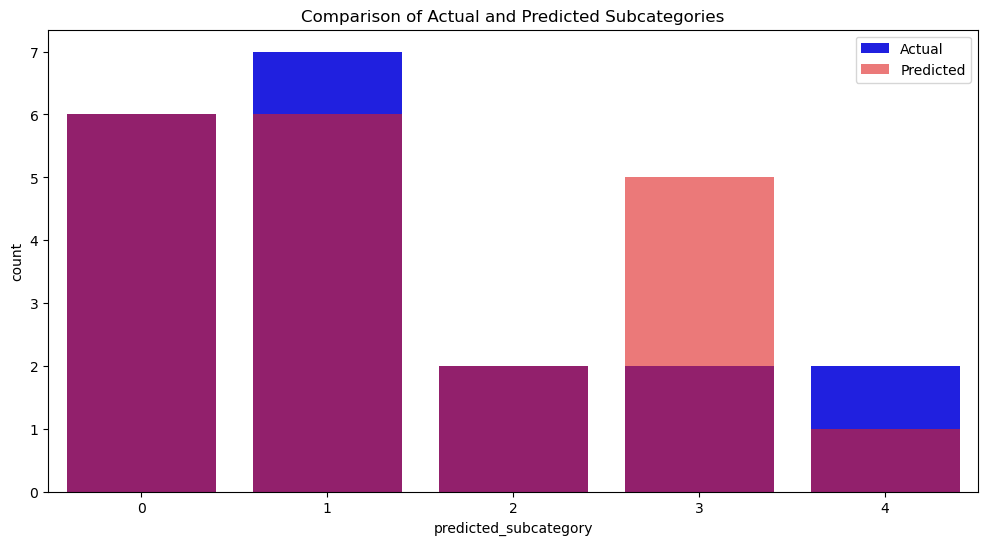

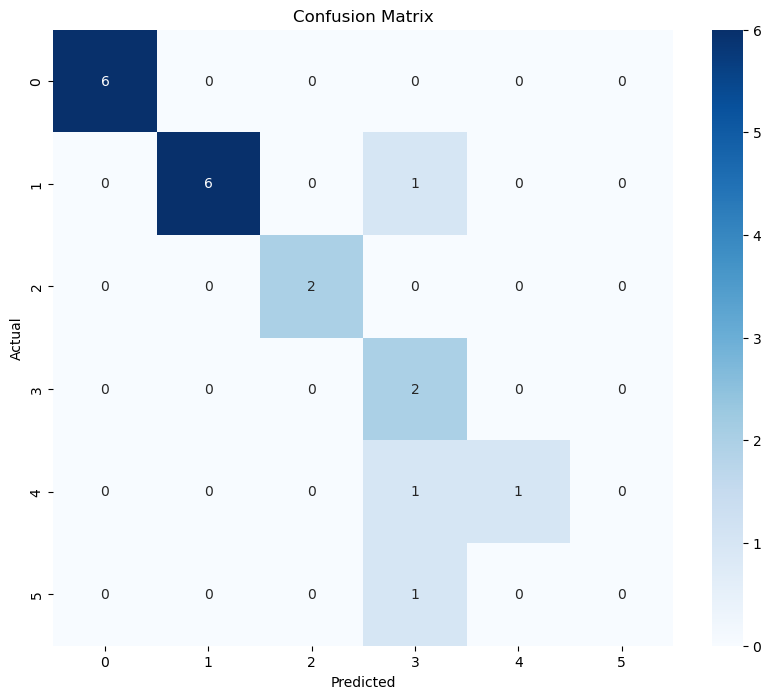

In [26]:
# First Test predicting on small sample of bikes before running on entire datatset.

# Import necessary libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Function to load the model and make predictions
def predict_bike_type(features):
    # Load the trained model from the file
    with open('bike_type_classifier.pkl', 'rb') as file:
        model = pickle.load(file)
    # Make predictions
    return model.predict(features)

# Load data and make predictions
def load_data_and_predict(csv_file_path, target_column):
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Store 'id' column separately
    ids = df['id']
    
    # Prepare features; assume all columns except target and 'id' are features
    features = df.drop(columns=[target_column, 'id'])
    
    # Predict subcategories
    predictions = predict_bike_type(features)
    df['predicted_subcategory'] = predictions
    
    # Add 'id' back to the DataFrame
    df['id'] = ids
    
    # Print the DataFrame with the original and predicted categories along with id
    print("Original and Predicted Subcategories with IDs:")
    print(df[['id', target_column, 'predicted_subcategory']])
    
    # Optionally, to view how many items belong to each predicted subcategory
    print("\nItems per Predicted Subcategory:")
    print(df['predicted_subcategory'].value_counts())

    # Visualization 1: Bar plot of Actual vs Predicted categories
    plt.figure(figsize=(12, 6))
    sns.countplot(x=target_column, data=df, color='blue', label='Actual')
    sns.countplot(x='predicted_subcategory', data=df, color='red', alpha=0.6, label='Predicted')
    plt.title('Comparison of Actual and Predicted Subcategories')
    plt.legend()
    plt.show()

    # Visualization 2: Heatmap of the confusion matrix
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Enter Data:
if __name__ == "__main__":
    csv_file_path = 'sample_road_bikes_2020-2024.csv'  # Replace with the path to your dataset
    target_column = 'subcategory'  # Replace with the name of your target column
    load_data_and_predict(csv_file_path, target_column)


Accuracy of predictions: 98.69%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26618
           1       0.99      0.97      0.98     16636
           2       1.00      0.99      1.00     13356
           3       0.91      0.98      0.94      5999
           4       0.98      0.95      0.96      2822
           5       1.00      0.99      1.00      2595
           6       1.00      0.98      0.99      1341
           7       0.99      0.86      0.92       327
           8       1.00      0.97      0.99       340

    accuracy                           0.99     70034
   macro avg       0.98      0.97      0.98     70034
weighted avg       0.99      0.99      0.99     70034



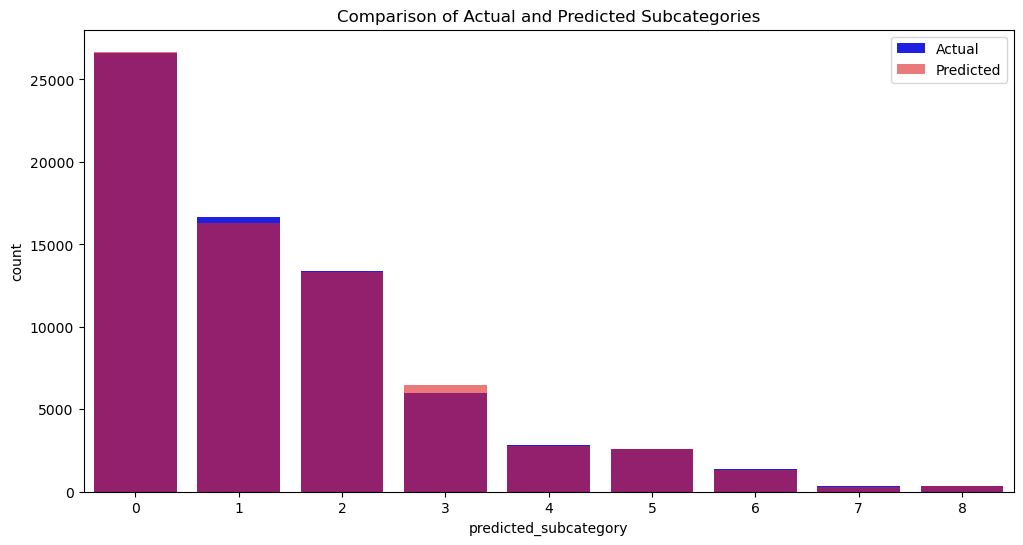

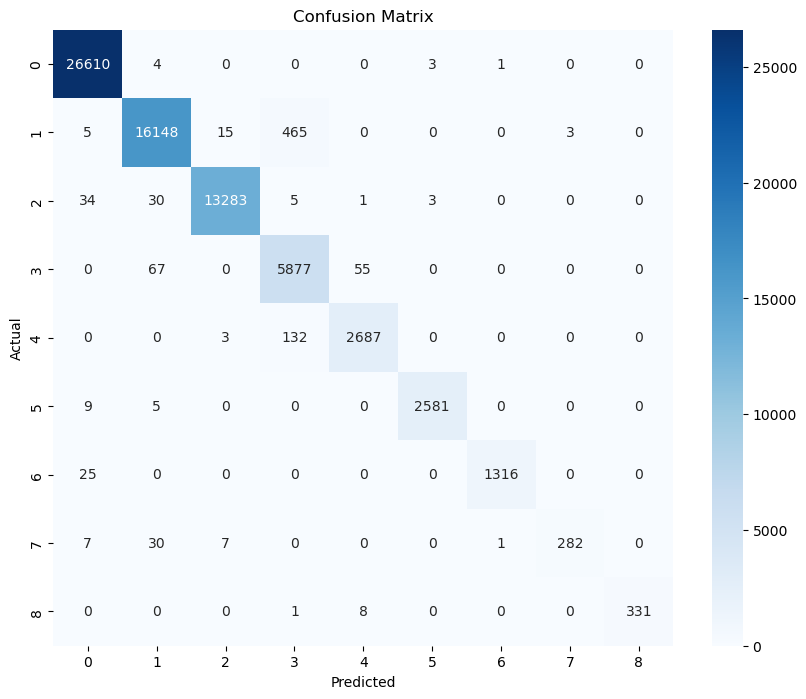

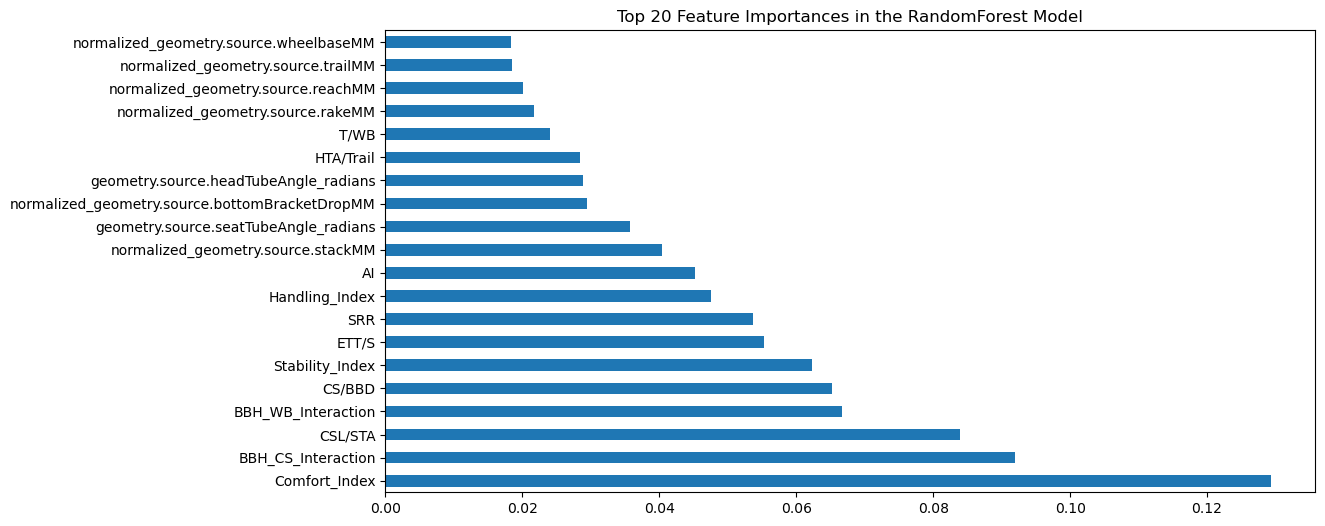

In [16]:
# Testing visuals 

# Import necessary libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# Function to load the model and make predictions
def predict_bike_type(features):
    # Load the trained model from the file
    with open('bike_type_classifier.pkl', 'rb') as file:
        model = pickle.load(file)
    # Make predictions
    return model.predict(features)

# Load data and make predictions
def load_data_and_predict(csv_file_path, target_column):
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Prepare features; assume all columns except target and 'id' are features
    features = df.drop(columns=[target_column, 'subcategory'])  # Exclude 'id' from features if present
    
    # Predict subcategories
    df['predicted_subcategory'] = predict_bike_type(features)
    
    # Calculate accuracy
    accuracy = accuracy_score(df[target_column], df['predicted_subcategory'])
    print(f"Accuracy of predictions: {accuracy:.2%}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(df[target_column], df['predicted_subcategory']))

    # Visualization 1: Bar plot of Actual vs Predicted categories
    plt.figure(figsize=(12, 6))
    sns.countplot(x=target_column, data=df, color='blue', label='Actual')
    sns.countplot(x='predicted_subcategory', data=df, color='red', alpha=0.6, label='Predicted')
    plt.title('Comparison of Actual and Predicted Subcategories')
    plt.legend()
    plt.show()

    # Visualization 2: Heatmap of the confusion matrix
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(df[target_column]), yticklabels=unique_labels(df[target_column]))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Visualization 3: Feature Importance
    with open('bike_type_classifier.pkl', 'rb') as file:
        model = pickle.load(file)
    plt.figure(figsize=(12, 6))
    feature_importances = pd.Series(model.feature_importances_, index=features.columns)
    feature_importances.nlargest(20).plot(kind='barh')
    plt.title('Top 20 Feature Importances in the RandomForest Model')
    plt.show()

# Enter Data:
if __name__ == "__main__":
    csv_file_path = 'encoded_road_bikes_2020-2024.csv'  # Replace with the path to your dataset
    target_column = 'subcategory'  # Replace with the name of your target column
    load_data_and_predict(csv_file_path, target_column)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26618
           1       0.99      0.97      0.98     16636
           2       1.00      0.99      1.00     13356
           3       0.91      0.98      0.94      5999
           4       0.98      0.95      0.96      2822
           5       1.00      0.99      1.00      2595
           6       1.00      0.98      0.99      1341
           7       0.99      0.86      0.92       327
           8       1.00      0.97      0.99       340

    accuracy                           0.99     70034
   macro avg       0.98      0.97      0.98     70034
weighted avg       0.99      0.99      0.99     70034



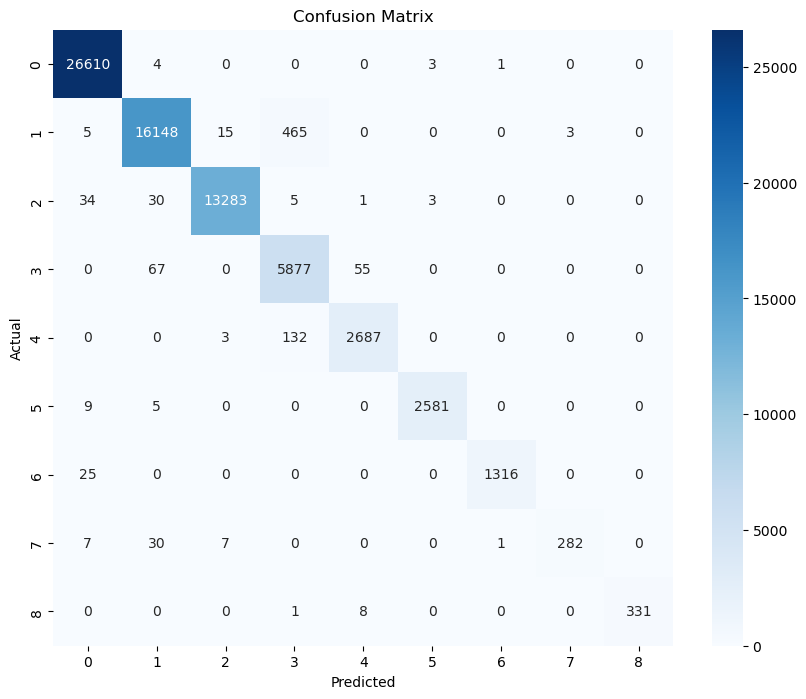

Most common misclassification: 1 predicted as 3 with 465 instances.

All Misclassifications:
    Actual  Predicted  Count  Percentage
0        0          1      4    0.015027
1        0          5      3    0.011271
2        0          6      1    0.003757
3        1          0      5    0.030055
4        1          2     15    0.090166
5        1          3    465    2.795143
6        1          7      3    0.018033
7        2          0     34    0.254567
8        2          1     30    0.224618
9        2          3      5    0.037436
10       2          4      1    0.007487
11       2          5      3    0.022462
12       3          1     67    1.116853
13       3          4     55    0.916819
14       4          2      3    0.106308
15       4          3    132    4.677534
16       5          0      9    0.346821
17       5          1      5    0.192678
18       6          0     25    1.864280
19       7          0      7    2.140673
20       7          1     30    9.174312
21   

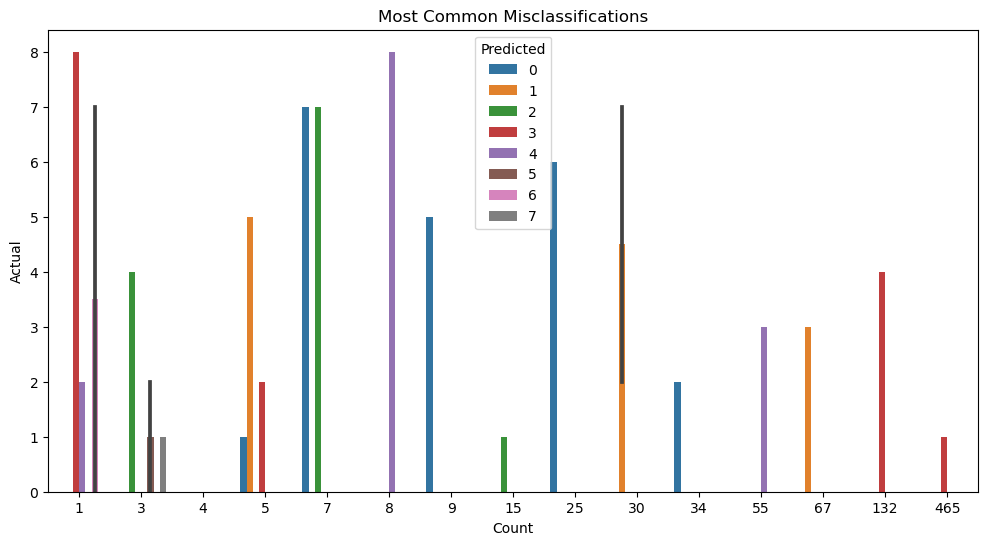

In [11]:
# Error analysis

# Import necessary libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Function to load the model and make predictions
def predict_bike_type(features):
    # Load the trained model from the file
    with open('bike_type_classifier.pkl', 'rb') as file:
        model = pickle.load(file)
    # Make predictions
    return model.predict(features)

# Function to analyze errors
def analyze_errors(df, target_column):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    labels = unique_labels(df[target_column])
    
    # Find the most common misclassification
    errors = [(labels[i], labels[j], conf_matrix[i, j]) for i in range(len(labels)) for j in range(len(labels)) if i != j]
    most_common_error = max(errors, key=lambda x: x[2])
    
    print(f"Most common misclassification: {most_common_error[0]} predicted as {most_common_error[1]} with {most_common_error[2]} instances.")

    # Count of each type of misclassification
    misclassifications = [(labels[i], labels[j], conf_matrix[i, j]) for i in range(len(labels)) for j in range(len(labels)) if i != j and conf_matrix[i, j] > 0]
    misclassifications_df = pd.DataFrame(misclassifications, columns=['Actual', 'Predicted', 'Count'])
    
    # Calculate the percentage of each misclassification
    total_counts = df[target_column].value_counts().to_dict()
    misclassifications_df['Percentage'] = misclassifications_df.apply(lambda row: (row['Count'] / total_counts[row['Actual']]) * 100, axis=1)
    
    print("\nAll Misclassifications:")
    print(misclassifications_df)
    
    # Plot most common misclassifications
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Actual', hue='Predicted', data=misclassifications_df)
    plt.title('Most Common Misclassifications')
    plt.show()
    
    return most_common_error

# Function to load data and perform error analysis
def load_data_and_analyze_errors(csv_file_path, target_column):
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Prepare features; assume all columns except target are features
    features = df.drop(columns=[target_column])
    
    # Predict subcategories
    df['predicted_subcategory'] = predict_bike_type(features)
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(df[target_column], df['predicted_subcategory']))

    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(df[target_column]), yticklabels=unique_labels(df[target_column]))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Analyze errors
    most_common_error = analyze_errors(df, target_column)
    
    return df, most_common_error

# Enter Data: 
if __name__ == "__main__":
    csv_file_path = 'encoded_road_bikes_2020-2024.csv'  # Replace with the path to your dataset
    target_column = 'subcategory'  # Replace with the name of your target column
    df, most_common_error = load_data_and_analyze_errors(csv_file_path, target_column)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26618
           1       0.99      0.97      0.98     16636
           2       1.00      0.99      1.00     13356
           3       0.91      0.98      0.94      5999
           4       0.98      0.95      0.96      2822
           5       1.00      0.99      1.00      2595
           6       1.00      0.98      0.99      1341
           7       0.99      0.86      0.92       327
           8       1.00      0.97      0.99       340

    accuracy                           0.99     70034
   macro avg       0.98      0.97      0.98     70034
weighted avg       0.99      0.99      0.99     70034



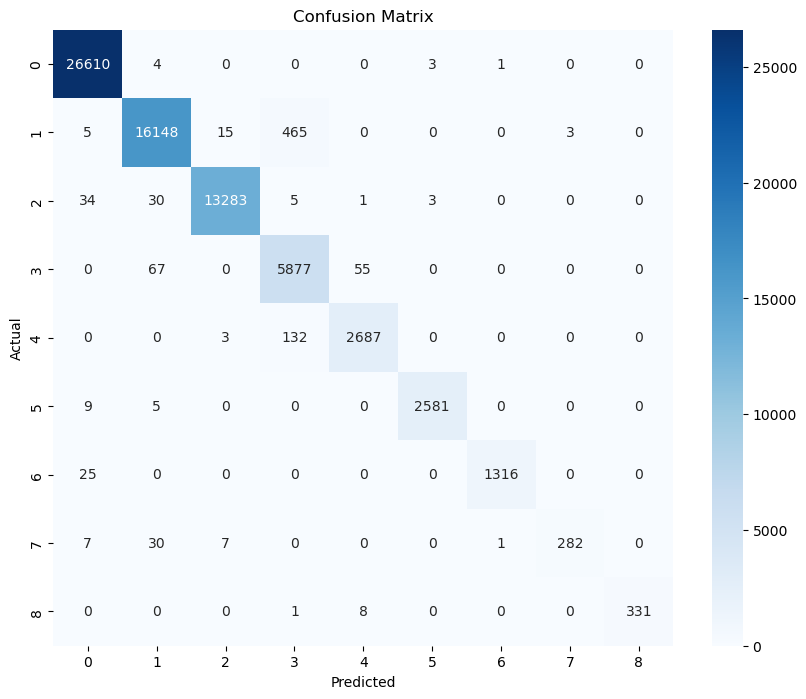

Most common misclassification: 1 predicted as 3 with 465 instances.

All Misclassifications:
    Actual  Predicted  Count  Percentage
0        0          1      4    0.015027
1        0          5      3    0.011271
2        0          6      1    0.003757
3        1          0      5    0.030055
4        1          2     15    0.090166
5        1          3    465    2.795143
6        1          7      3    0.018033
7        2          0     34    0.254567
8        2          1     30    0.224618
9        2          3      5    0.037436
10       2          4      1    0.007487
11       2          5      3    0.022462
12       3          1     67    1.116853
13       3          4     55    0.916819
14       4          2      3    0.106308
15       4          3    132    4.677534
16       5          0      9    0.346821
17       5          1      5    0.192678
18       6          0     25    1.864280
19       7          0      7    2.140673
20       7          1     30    9.174312
21   

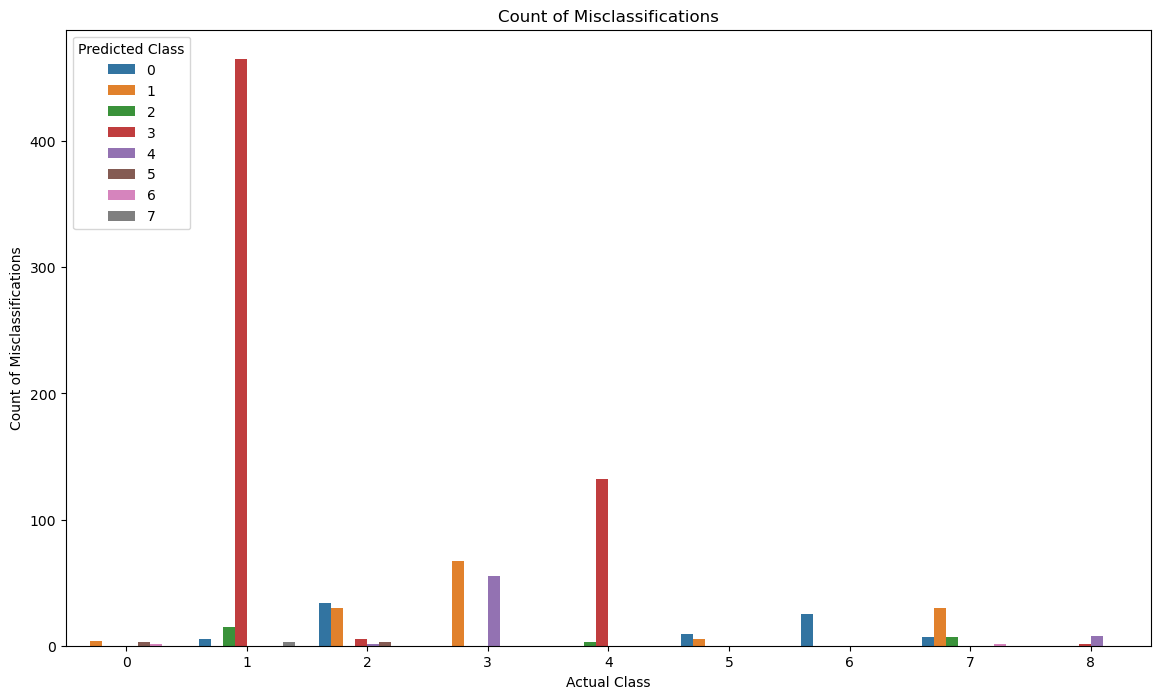

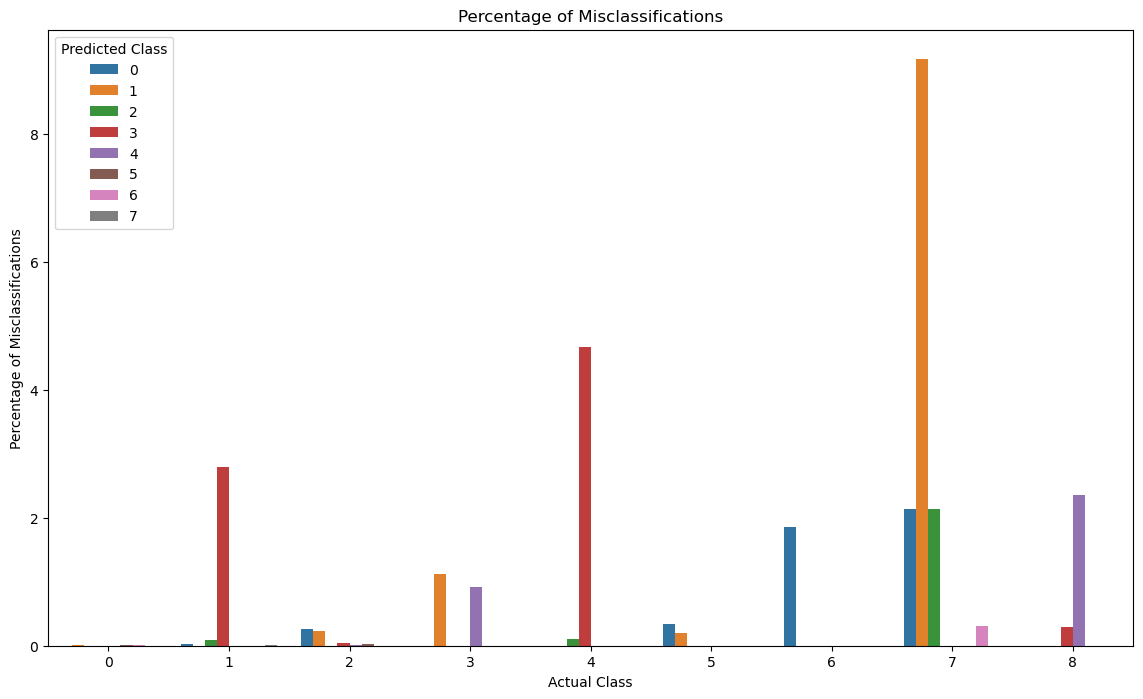

In [3]:
# Visualisation of All Misclassifications

# Error analysis

# Import necessary libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from collections import Counter

# Function to load the model and make predictions
def predict_bike_type(features):
    # Load the trained model from the file
    with open('bike_type_classifier.pkl', 'rb') as file:
        model = pickle.load(file)
    # Make predictions
    return model.predict(features)

# Function to analyze errors
def analyze_errors(df, target_column):
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    labels = unique_labels(df[target_column])
    
    # Find the most common misclassification
    errors = [(labels[i], labels[j], conf_matrix[i, j]) for i in range(len(labels)) for j in range(len(labels)) if i != j]
    most_common_error = max(errors, key=lambda x: x[2])
    
    print(f"Most common misclassification: {most_common_error[0]} predicted as {most_common_error[1]} with {most_common_error[2]} instances.")

    # Count of each type of misclassification
    misclassifications = [(labels[i], labels[j], conf_matrix[i, j]) for i in range(len(labels)) for j in range(len(labels)) if i != j and conf_matrix[i, j] > 0]
    misclassifications_df = pd.DataFrame(misclassifications, columns=['Actual', 'Predicted', 'Count'])
    
    # Calculate the percentage of each misclassification
    total_counts = df[target_column].value_counts().to_dict()
    misclassifications_df['Percentage'] = misclassifications_df.apply(lambda row: (row['Count'] / total_counts[row['Actual']]) * 100, axis=1)
    
    print("\nAll Misclassifications:")
    print(misclassifications_df)
    
    # Plot count of misclassifications
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Actual', y='Count', hue='Predicted', data=misclassifications_df)
    plt.title('Count of Misclassifications')
    plt.xlabel('Actual Class')
    plt.ylabel('Count of Misclassifications')
    plt.legend(title='Predicted Class')
    plt.show()
    
    # Plot percentage of misclassifications
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Actual', y='Percentage', hue='Predicted', data=misclassifications_df)
    plt.title('Percentage of Misclassifications')
    plt.xlabel('Actual Class')
    plt.ylabel('Percentage of Misclassifications')
    plt.legend(title='Predicted Class')
    plt.show()
    
    return most_common_error

# Function to load data and perform error analysis
def load_data_and_analyze_errors(csv_file_path, target_column):
    # Load the dataset
    df = pd.read_csv(csv_file_path)
    
    # Prepare features; assume all columns except target are features
    features = df.drop(columns=[target_column])
    
    # Predict subcategories
    df['predicted_subcategory'] = predict_bike_type(features)
    
    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(df[target_column], df['predicted_subcategory']))

    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(df[target_column], df['predicted_subcategory'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels(df[target_column]), yticklabels=unique_labels(df[target_column]))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Analyze errors
    most_common_error = analyze_errors(df, target_column)
    
    return df, most_common_error

# Enter Data:
if __name__ == "__main__":
    csv_file_path = 'encoded_road_bikes_2020-2024.csv'  # Replace with the path to your dataset
    target_column = 'subcategory'  # Replace with the name of your target column
    df, most_common_error = load_data_and_analyze_errors(csv_file_path, target_column)
